In [ ]:
from IPython.display import display, Markdown
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
import kagglehub
import math
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import scipy.stats as ss
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Decide between local or kaggle cloud storage         
KAGGLE_ENV = 'kaggle' in os.listdir('/')
data_path = '/kaggle/input' if KAGGLE_ENV else '../kaggle/input'
    
    
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        print(os.path.join(dirname, filename)) 

../kaggle/input/submission.csv
../kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv
../kaggle/input/playground-series-s4e11/sample_submission.csv
../kaggle/input/playground-series-s4e11/test.csv
../kaggle/input/playground-series-s4e11/train.csv


# Load Data

In [74]:
# Load the data
train_original = pd.read_csv(data_path + '/playground-series-s4e11/train.csv')
test_original = pd.read_csv(data_path + '/playground-series-s4e11/test.csv')
sample_submission = pd.read_csv(data_path + '/playground-series-s4e11/sample_submission.csv')
original_data = pd.read_csv(data_path + '/depression-surveydataset-for-analysis/final_depression_dataset_1.csv')

# Preprocessing

In [75]:

def get_categorical_numerical_features(df):
    # Get Numeric & Categorical Features
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
    return numeric_features, categorical_features

numeric_features, categorical_features = get_categorical_numerical_features(train_original)

# Outliers (optional)
Repair or delete outliers.

**=> Didnt find any**

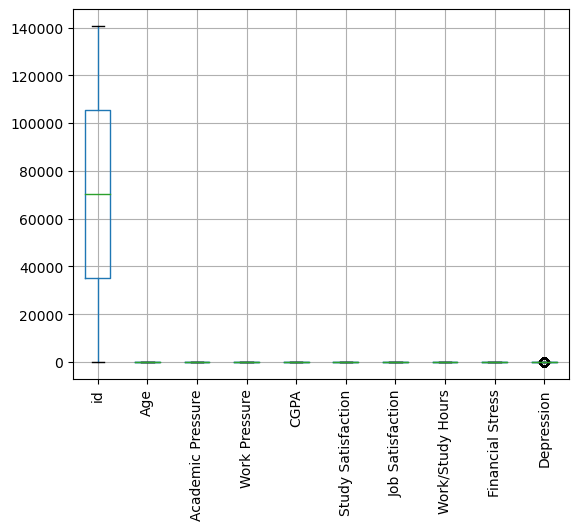

In [76]:
# Chose only numerical columns
train_numeric = train_original.select_dtypes(include=[np.number])
train_numeric.boxplot(rot=90)
plt.show()

In [77]:
z_scores = np.abs((train_numeric - train_numeric.mean()) / train_numeric.std(ddof=0))
# indentify Outliers (Z-Score > 3)
outliers = train_original[(z_scores > 3).any(axis=1)]
print(outliers)

Empty DataFrame
Columns: [id, Name, Gender, Age, City, Working Professional or Student, Profession, Academic Pressure, Work Pressure, CGPA, Study Satisfaction, Job Satisfaction, Sleep Duration, Dietary Habits, Degree, Have you ever had suicidal thoughts ?, Work/Study Hours, Financial Stress, Family History of Mental Illness, Depression]
Index: []


# Missing Data
Create or delete missing data
There different ways to do that:
- MICE (Multiple Imputation by Chained Equations)

In [78]:
missing_data = train_original.isnull().sum()
print(missing_data)

id                                            0
Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                36630
Academic Pressure                        112803
Work Pressure                             27918
CGPA                                     112802
Study Satisfaction                       112803
Job Satisfaction                          27910
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
dtype: int64


In [79]:
train_original.head(20)

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0
5,5,Vani,Female,59.0,Ahmedabad,Working Professional,Finanancial Analyst,NaN,2.0,NaN,NaN,5.0,5-6 hours,Healthy,MCA,No,7.0,5.0,No,0
6,6,Ritvik,Male,47.0,Thane,Working Professional,Chemist,NaN,5.0,NaN,NaN,2.0,7-8 hours,Moderate,MD,No,6.0,2.0,No,0
7,7,Rajveer,Male,38.0,Nashik,Working Professional,Teacher,NaN,3.0,NaN,NaN,4.0,7-8 hours,Unhealthy,B.Pharm,No,10.0,3.0,Yes,0
8,8,Aishwarya,Female,24.0,Bangalore,Student,NaN,2.0,NaN,5.90,5.0,NaN,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
9,9,Simran,Female,42.0,Patna,Working Professional,Electrician,NaN,4.0,NaN,NaN,1.0,5-6 hours,Healthy,ME,Yes,7.0,2.0,Yes,0


## MICE (Multiple Imputation by Chained Equations)
**We don't use MICE**, at the train data there is not enough correlation between the features (none of them > +/- 0.7!)

In [80]:
#imputer = IterativeImputer()
#df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [81]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cramers_v(train_original['Age'], train_original['Depression'])

0.6317111476837902

## KNN Imputer (k-Nearest Neighbors)
**Takes way too long for this dataset**

In [82]:
# imputer = KNNImputer(n_neighbors=3)  # k=5 nearest neighbors
# print("Start KNN-Imputation...")
# train_original[numeric_features] = imputer.fit_transform(train_original[numeric_features])# only for numerical data
# print(train_original)

# IterativeImputer (like MissForest)
**still not good** CGPA is negative..

In [83]:
imputer = IterativeImputer()
df_imputed = imputer.fit_transform(train_original[numeric_features])
df_final = pd.DataFrame(df_imputed, columns=numeric_features)

# Automatic detection of integer features (if they were previously only integers)
integer_features = [col for col in numeric_features if train_original[col].dropna().mod(1).eq(0).all()]
df_final[integer_features] = df_final[integer_features].round().astype(int)

print("Iterative Imputation done")

Iterative Imputation done


In [84]:
df_final.head(25)

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
0,0,49,3,5,7.538038,3,2,1,2,0
1,1,26,3,4,-17.754725,3,3,7,3,1
2,2,33,5,4,8.970000,2,2,3,1,1
3,3,22,3,5,29.657022,3,1,10,1,1
4,4,30,3,1,104.431810,3,1,9,4,0
5,5,59,3,2,-43.585742,3,5,7,5,0
6,6,47,3,5,6.716409,3,2,6,2,0
7,7,38,3,3,-23.390103,3,4,10,3,0
8,8,24,2,3,5.900000,5,3,3,2,0
9,9,42,3,4,54.865288,3,1,7,2,0


# IterativeImputer with RandomForestRegressor
**looks like a good solution**

In [85]:
# Function to separate numerical features by type
def get_feature_types(df):
    int_features = [col for col in df.columns if df[col].dropna().mod(1).eq(0).all()]  # integer only
    float_features = [col for col in df.columns if col not in int_features]  # everything else
    return int_features, float_features

int_features, float_features = get_feature_types(train_original[numeric_features])

# Iterative Imputation with RandomForest (better for discrete values than Bayesian Ridge)
imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=50, random_state=42), random_state=42)
df_imputed = imputer.fit_transform(train_original[numeric_features])
train_numerical_processed = pd.DataFrame(df_imputed, columns=numeric_features)

# Processing by feature type
train_numerical_processed[int_features] = train_numerical_processed[int_features].round().astype(int)  # cast int
train_numerical_processed[float_features] = train_numerical_processed[float_features].round(2)  

print("Iterative Imputation - Done")

Iterative Imputation - Done


In [86]:
train_numerical_processed.head(25)

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
0,0,49,3,5,7.23,3,2,1,2,0
1,1,26,4,4,8.47,2,3,7,3,1
2,2,33,5,4,8.97,2,3,3,1,1
3,3,22,3,5,7.25,3,1,10,1,1
4,4,30,3,1,7.43,3,1,9,4,0
5,5,59,3,2,7.13,3,5,7,5,0
6,6,47,3,5,7.34,3,2,6,2,0
7,7,38,2,3,7.30,4,4,10,3,0
8,8,24,2,3,5.90,5,3,3,2,0
9,9,42,3,4,7.30,3,1,7,2,0


In [87]:
train_preprocessed = pd.concat([train_original[categorical_features], train_numerical_processed], axis=1)
train_preprocessed.head(25)

,Name,Gender,City,Working Professional or Student,Profession,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Family History of Mental Illness,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
0,Aaradhya,Female,Ludhiana,Working Professional,Chef,More than 8 hours,Healthy,BHM,No,No,0,49,3,5,7.23,3,2,1,2,0
1,Vivan,Male,Varanasi,Working Professional,Teacher,Less than 5 hours,Unhealthy,LLB,Yes,No,1,26,4,4,8.47,2,3,7,3,1
2,Yuvraj,Male,Visakhapatnam,Student,NaN,5-6 hours,Healthy,B.Pharm,Yes,No,2,33,5,4,8.97,2,3,3,1,1
3,Yuvraj,Male,Mumbai,Working Professional,Teacher,Less than 5 hours,Moderate,BBA,Yes,Yes,3,22,3,5,7.25,3,1,10,1,1
4,Rhea,Female,Kanpur,Working Professional,Business Analyst,5-6 hours,Unhealthy,BBA,Yes,Yes,4,30,3,1,7.43,3,1,9,4,0
5,Vani,Female,Ahmedabad,Working Professional,Finanancial Analyst,5-6 hours,Healthy,MCA,No,No,5,59,3,2,7.13,3,5,7,5,0
6,Ritvik,Male,Thane,Working Professional,Chemist,7-8 hours,Moderate,MD,No,No,6,47,3,5,7.34,3,2,6,2,0
7,Rajveer,Male,Nashik,Working Professional,Teacher,7-8 hours,Unhealthy,B.Pharm,No,Yes,7,38,2,3,7.30,4,4,10,3,0
8,Aishwarya,Female,Bangalore,Student,NaN,5-6 hours,Moderate,BSc,No,Yes,8,24,2,3,5.90,5,3,3,2,0
9,Simran,Female,Patna,Working Professional,Electrician,5-6 hours,Healthy,ME,Yes,Yes,9,42,3,4,7.30,3,1,7,2,0


In [88]:
print(train_preprocessed.isnull().sum())

Name                                         0
Gender                                       0
City                                         0
Working Professional or Student              0
Profession                               36630
Sleep Duration                               0
Dietary Habits                               4
Degree                                       2
Have you ever had suicidal thoughts ?        0
Family History of Mental Illness             0
id                                           0
Age                                          0
Academic Pressure                            0
Work Pressure                                0
CGPA                                         0
Study Satisfaction                           0
Job Satisfaction                             0
Work/Study Hours                             0
Financial Stress                             0
Depression                                   0
dtype: int64


# Fix categorical missing data

In [ ]:
train_preprocessed_copy = train_preprocessed.copy()

feature_with_missing = "Profession"

df_missing = train_preprocessed_copy[train_preprocessed_copy[feature_with_missing].isnull()].copy()
df_complete = train_preprocessed_copy.dropna(subset=[feature_with_missing]).copy()

if df_missing.empty:
    print("No Missing Data at 'Profession'")
else:
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    encoder.fit(df_complete[[feature_with_missing]])
    df_complete.loc[:, [feature_with_missing]] = encoder.transform(df_complete[[feature_with_missing]])
    df_missing[feature_with_missing] = df_missing[feature_with_missing].fillna("MISSING_CATEGORY")
    df_missing.loc[:, [feature_with_missing]] = encoder.transform(df_missing[[feature_with_missing]])
    imputer = IterativeImputer(estimator=RandomForestClassifier(n_estimators=10, random_state=42), random_state=42)
    df_missing[[feature_with_missing]] = imputer.fit(df_complete[[feature_with_missing]]).transform(df_missing[[feature_with_missing]])


    max_category_index = len(encoder.categories_[0]) - 1
    df_missing[feature_with_missing] = np.clip(df_missing[feature_with_missing], 0, max_category_index)
    df_missing[feature_with_missing] = df_missing[feature_with_missing].astype(int)
    df_missing[feature_with_missing] = encoder.inverse_transform(df_missing[[feature_with_missing]].to_numpy().reshape(-1, 1)).ravel()
    df_missing[feature_with_missing] = df_missing[feature_with_missing].astype(str)
    df_complete[feature_with_missing] = encoder.inverse_transform(df_complete[[feature_with_missing]].to_numpy().reshape(-1, 1)).ravel()

    df_missing = df_missing.sort_index()
    df_complete = df_complete.sort_index()

    train_preprocessed = pd.concat([df_complete, df_missing])
    train_preprocessed[feature_with_missing] = train_preprocessed[feature_with_missing].astype(str)

In [90]:
df_complete.head(25)

,Name,Gender,City,Working Professional or Student,Profession,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Family History of Mental Illness,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
0,Aaradhya,Female,Ludhiana,Working Professional,Chef,More than 8 hours,Healthy,BHM,No,No,0,49,3,5,7.23,3,2,1,2,0
1,Vivan,Male,Varanasi,Working Professional,Teacher,Less than 5 hours,Unhealthy,LLB,Yes,No,1,26,4,4,8.47,2,3,7,3,1
3,Yuvraj,Male,Mumbai,Working Professional,Teacher,Less than 5 hours,Moderate,BBA,Yes,Yes,3,22,3,5,7.25,3,1,10,1,1
4,Rhea,Female,Kanpur,Working Professional,Business Analyst,5-6 hours,Unhealthy,BBA,Yes,Yes,4,30,3,1,7.43,3,1,9,4,0
5,Vani,Female,Ahmedabad,Working Professional,Finanancial Analyst,5-6 hours,Healthy,MCA,No,No,5,59,3,2,7.13,3,5,7,5,0
6,Ritvik,Male,Thane,Working Professional,Chemist,7-8 hours,Moderate,MD,No,No,6,47,3,5,7.34,3,2,6,2,0
7,Rajveer,Male,Nashik,Working Professional,Teacher,7-8 hours,Unhealthy,B.Pharm,No,Yes,7,38,2,3,7.30,4,4,10,3,0
9,Simran,Female,Patna,Working Professional,Electrician,5-6 hours,Healthy,ME,Yes,Yes,9,42,3,4,7.30,3,1,7,2,0
10,Utkarsh,Male,Rajkot,Working Professional,Software Engineer,7-8 hours,Moderate,BSc,No,Yes,10,55,3,3,7.20,3,2,6,4,0
11,Aahana,Female,Patna,Working Professional,Teacher,7-8 hours,Moderate,B.Arch,No,No,11,51,3,1,7.04,4,2,9,5,0


In [91]:
df_missing.head(25)

,Name,Gender,City,Working Professional or Student,Profession,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Family History of Mental Illness,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
2,Yuvraj,Male,Visakhapatnam,Student,Academic,5-6 hours,Healthy,B.Pharm,Yes,No,2,33,5,4,8.97,2,3,3,1,1
8,Aishwarya,Female,Bangalore,Student,Academic,5-6 hours,Moderate,BSc,No,Yes,8,24,2,3,5.90,5,3,3,2,0
26,Aditya,Male,Srinagar,Student,Academic,Less than 5 hours,Healthy,BA,No,Yes,26,31,3,3,7.03,5,3,9,1,0
29,Kashish,Female,Agra,Working Professional,Academic,More than 8 hours,Healthy,Class 12,No,No,29,19,2,1,7.00,2,5,5,2,0
30,Prisha,Female,Varanasi,Student,Academic,7-8 hours,Moderate,BCA,Yes,Yes,30,28,3,4,5.59,2,3,4,5,1
32,Chhavi,Female,Jaipur,Student,Academic,5-6 hours,Moderate,M.Tech,Yes,No,32,25,4,3,8.13,3,3,1,1,0
33,Tanmay,Male,Pune,Student,Academic,Less than 5 hours,Healthy,PhD,No,No,33,29,2,3,5.70,3,3,4,1,0
36,Anvi,Female,Kalyan,Working Professional,Academic,7-8 hours,Unhealthy,Class 12,No,No,36,50,2,4,7.65,4,4,0,2,0
43,Vidya,Female,Vadodara,Working Professional,Academic,Less than 5 hours,Moderate,Class 12,Yes,No,43,18,4,5,7.59,3,4,10,5,1
48,Anand,Male,Ghaziabad,Working Professional,Academic,5-6 hours,Moderate,Class 12,No,Yes,48,38,3,2,7.16,3,5,1,1,0


In [92]:
train_preprocessed.head(25)

,Name,Gender,City,Working Professional or Student,Profession,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Family History of Mental Illness,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
0,Aaradhya,Female,Ludhiana,Working Professional,Chef,More than 8 hours,Healthy,BHM,No,No,0,49,3,5,7.23,3,2,1,2,0
1,Vivan,Male,Varanasi,Working Professional,Teacher,Less than 5 hours,Unhealthy,LLB,Yes,No,1,26,4,4,8.47,2,3,7,3,1
3,Yuvraj,Male,Mumbai,Working Professional,Teacher,Less than 5 hours,Moderate,BBA,Yes,Yes,3,22,3,5,7.25,3,1,10,1,1
4,Rhea,Female,Kanpur,Working Professional,Business Analyst,5-6 hours,Unhealthy,BBA,Yes,Yes,4,30,3,1,7.43,3,1,9,4,0
5,Vani,Female,Ahmedabad,Working Professional,Finanancial Analyst,5-6 hours,Healthy,MCA,No,No,5,59,3,2,7.13,3,5,7,5,0
6,Ritvik,Male,Thane,Working Professional,Chemist,7-8 hours,Moderate,MD,No,No,6,47,3,5,7.34,3,2,6,2,0
7,Rajveer,Male,Nashik,Working Professional,Teacher,7-8 hours,Unhealthy,B.Pharm,No,Yes,7,38,2,3,7.30,4,4,10,3,0
9,Simran,Female,Patna,Working Professional,Electrician,5-6 hours,Healthy,ME,Yes,Yes,9,42,3,4,7.30,3,1,7,2,0
10,Utkarsh,Male,Rajkot,Working Professional,Software Engineer,7-8 hours,Moderate,BSc,No,Yes,10,55,3,3,7.20,3,2,6,4,0
11,Aahana,Female,Patna,Working Professional,Teacher,7-8 hours,Moderate,B.Arch,No,No,11,51,3,1,7.04,4,2,9,5,0


In [93]:
train_preprocessed.isnull().sum()

Name                                     0
Gender                                   0
City                                     0
Working Professional or Student          0
Profession                               0
Sleep Duration                           0
Dietary Habits                           4
Degree                                   2
Have you ever had suicidal thoughts ?    0
Family History of Mental Illness         0
id                                       0
Age                                      0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Work/Study Hours                         0
Financial Stress                         0
Depression                               0
dtype: int64

# Fine Tuning
Delete the couple rows that have missing values

In [ ]:
print("Before:"train_preprocessed.shape[0])
train_preprocessed= train_preprocessed.dropna()
print("After:", train_preprocessed.shape[0])
train_preprocessed.isnull().sum()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3180302782.py, line 1)

# Feature Selection (optional)
Delete attributes there aren't providing any information (correlation matrix).

# Create new Features (optional)
- Discretizing Continuous Features
- Decomposing Features and Date/Time Variables
- Aggregate attributes to better new attributes

# Scale Features: Standard or Normalize, Encodes categorical features